# Train and Predict
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [1]:
# ! pip install zipfile -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 1
import sys
import os
import gc
from time import time
from datetime import timedelta, datetime
import base64
import warnings
from collections import defaultdict
from tqdm import tqdm

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics
from dinglingling import wx_reminder

sys.path.append('../')
import conf
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
from utils import (
    check_columns,
    check_nan_value,
    correct_column_type,
    load_model,
    plot_dist_of_cols,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# global variables
SCKEY = 'SCU92138T03d57ff9d4b08ced24c2cceb440cd3bd5e843242680de'  # used for reminding when feature engineering or model training completes

In [4]:
# functions
def __dummy():
    pass

@wx_reminder(SCKEY=SCKEY, remind_started=True)  
def feature_engineering_wrapper(params):
        """
        wrapper for feature engineering func 
        for reminding when it completes
        """
        fe_df = feature_engineering(**params)
        
        return fe_df    
    
@wx_reminder(SCKEY=SCKEY, remind_started=True)  
def tune_params_wrapper(params):
    results, best_params , feats_imp = train(**params) 
    return results, best_params, feats_imp

### <a id='1'> 1.lightgbm</a>

In [5]:
! du -sh ../data/*

8.1M	../data/2017_fault_data.h5
67M	../data/chunk_data_for_test.h5
4.2G	../data/code.zip
4.2G	../data/data_2017_all.h5
4.7G	../data/data_2017_new_all.h5
2.3G	../data/data_2017_tag_flag.h5
2.5G	../data/data_2017_tag_flag_raw.h5
12G	../data/data_2017_to_2018_all.h5
20M	../data/data_201808_test.h5
41M	../data/data_201808_test_all.h5
46M	../data/data_201808_test_b.h5
24M	../data/data_201808_test_raw.h5
6.9G	../data/data_2018_all.h5
7.9G	../data/data_2018_new_all.h5
2.5G	../data/data_2018_semifinals.h5
9.1G	../data/data_2018_semifinals_all.h5
3.9G	../data/data_2018_tag_flag.h5
4.2G	../data/data_2018_tag_flag_raw.h5
36K	../data/disk_sample_fault_tag.csv
8.0K	../data/disk_sample_fault_tag_201808.csv
1.2G	../data/disk_sample_smart_log_201707.csv
228M	../data/disk_sample_smart_log_201707_norm.csv
233M	../data/disk_sample_smart_log_201707_raw.csv
2.2G	../data/disk_sample_smart_log_201708.csv
446M	../data/disk_sample_smart_log_201708_norm.csv
460M	../data/disk_sample_smart_log_201708_raw.csv
2.2G

In [6]:
# feature engineering
params = {
    'filename':'data_2018_semifinals_all.h5', # file we want to load for feature engineering
    'fe_save_filename':'fe_df_01_01_round_2_submissionv1.1.feather',  # naming the train fe by the start date of train not include 2017 data date
    'use_2017_fault_data':True,
    'clip_start_date': '2018-01-01', # start date of data for doing feature engineering(not include 2017 data) e.g. 2018-02-01 
    'clip_end_date': '2018-08-31',  # end date of data for doing feature engineering e.g. 2018-06-30
    'use_model_id': None,  # 1,2 and None
    'is_train':True,
    'num_processes': 40,
}

fe_df = feature_engineering_wrapper(params)

2020-04-12 14:27:53,899 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-04-12 14:27:53,901 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: True，数据集截断起始日期：2018-01-01, 数据集截断结束日期：2018-08-31
2020-04-12 14:27:53,903 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-04-12 14:27:53,904 - mlpipeline.feature_engineering - INFO - 加载数据集: ../data/data_2018_semifinals_all.h5
2020-04-12 14:30:58,716 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['smart_1_normalized', 'smart_3_normalized', 'smart_7_normalized', 'smart_9_normalized',
       'smart_187_normalized', 'smart_189_normalized', 'smart_193_normalized',
       'smart_191_normalized', 'smart_195_normalized', 'smart_4raw', 'smart_5raw', 'smart_9raw',
       'smart_12raw', 'smart_184raw', 'smart_188raw', 'smart_192raw', 'smart_194raw',
       'smart_197raw', 'smart_198raw', 'smart_199raw', 'dt', 'serial_number', 'model', 'tag',
       'flag'],
      dtype='object')
2020-04-12 14:30:58,7

  0%|          | 222/179619 [00:04<52:47, 56.63it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  0%|          | 235/179619 [00:04<59:09, 50.54it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  0%|          | 244/179619 [00:05<51:28, 58.08it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
  0%|    

2020-04-12 15:43:32,854 - utils.utils - INFO - smart_191_normalized_max_7 - 0.0%
2020-04-12 15:43:33,237 - utils.utils - INFO - smart_195_normalized_max_7 - 0.0%
2020-04-12 15:43:33,622 - utils.utils - INFO - smart_4raw_max_7 - 0.0%
2020-04-12 15:43:34,008 - utils.utils - INFO - smart_5raw_max_7 - 0.0%
2020-04-12 15:43:34,393 - utils.utils - INFO - smart_12raw_max_7 - 0.0%
2020-04-12 15:43:34,781 - utils.utils - INFO - smart_192raw_max_7 - 0.0%
2020-04-12 15:43:35,164 - utils.utils - INFO - smart_194raw_max_7 - 0.0%
2020-04-12 15:43:35,545 - utils.utils - INFO - smart_199raw_max_7 - 0.0%
2020-04-12 15:43:35,930 - utils.utils - INFO - err_weight_max_7 - 0.0%
2020-04-12 15:43:36,316 - utils.utils - INFO - seek_err_weight_max_7 - 0.0%
2020-04-12 15:43:36,704 - utils.utils - INFO - degradation_err_weight_max_7 - 0.0%
2020-04-12 15:43:37,086 - utils.utils - INFO - smart_1_normalized_std_7 - 0.49%
2020-04-12 15:43:37,471 - utils.utils - INFO - smart_3_normalized_std_7 - 0.49%
2020-04-12 15:4

In [7]:
# drop_cols = [
#     'power_on_hours_in_day_unit_cate',
#     'smart_9raw',
#     'smart_187_normalized_max_7',
#      'smart_187_normalized_min_7',
#     'smart_187_normalized_diff_for_last_period_7',
#     'smart_187_normalized_std_7',
# #     'smart_9_normalized'
# ]
drop_cols = [
    'power_on_hours_in_day_unit_cate',
    'smart_9raw',
#     'smart_9_normalized'
]

In [8]:
# tune params
search_params_space = {
#                 'scale_pos_weight':[20,25,30],
                'num_leaves':[16,32,64],  # [16,32,64,128]
                'subsample':(0.7,0.99),  # [0.7,0.8,0.9,1]
                'colsample_bytree':(0.29,0.61), # [0.2,0.3,0.4,0.5,0.6]
                'min_data_in_leaf':[20,40,60,80,100,120], # [20,40,60,80,100]
                'lambda_l1':(0.2,3.5),  # (0.2,3)
                'lambda_l2':(0.2,3.5),  # (0.2,3)
                'focal_loss_alpha':(0.7, 0.99),
                'focal_loss_gamma':(0.9,3)
}

model_params = {
               'objective': 'binary',
               'boosting': 'gbdt',
               'learning_rate': 0.01,
               'metric': ['auc'],
               'num_threads': 15,
               'random_state': 2019,
               'num_boost_round': 1000,
               'device': 'cpu',}

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename':'sample_by_power_on_hours_0.3_fe_df_01_01_round_2_submission.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
    'is_eval': True,
    'use_log': False,
    'drop_cols':drop_cols,
    'random_state':1,
    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
    'use_2017_fault_data':False,
    'use_next_month_fault_data':True,
    'use_random_search':True,
    'use_cv':False,
    'random_search_times':10,
    'search_params_space':search_params_space,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
    
#     'use_sampling': True,
#     'train_sample_ratio':0.3,
#     'save_sample_data':True,
#     'use_sampling_by_month_with_weight':False,
#     'use_sampling_by_clustering_label':False,
#     'use_sampling_by_power_on_hours':True,
#     'train_date_list':[
#                       ('2018-01-01','2018-01-31'),
#                       ('2018-01-01','2018-02-28'),
#                       ('2018-01-01','2018-03-31'),
#                       ('2018-02-01','2018-04-30'),
#                       ('2018-01-01','2018-05-31')     
#     ],
#     'val_date_list':[
#                       ('2018-03-01','2018-03-31'),
#                       ('2018-04-01','2018-04-30'),
#                       ('2018-05-01','2018-05-31'),
#                       ('2018-06-01','2018-06-30'),
#                       ('2018-07-01','2018-07-31')
#      ],
#      'n_fold':5
}

2020-04-12 09:10:03,008 - mlpipeline.train - INFO - train开始
2020-04-12 09:10:03,011 - mlpipeline.train - INFO - 当前模式:eval, eval on model None, train on model None, 使用的数据集:sample_by_power_on_hours_0.3_fe_df_01_01_round_2_submission.feather, 当前使用模型:lgb, 使用cv: False, use_random_search: True, 训练集日期:2018-01-01 - 2018-05-31, 验证集日期:2018-07-01 - 2018-07-31, 分类阈值: 0.996, 截断个数: 40, 下采样：False, 上采样：False, 用的label：tag
2020-04-12 09:10:14,459 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-04-12 09:10:14,465 - mlpipeline.train - INFO - 连续性特征数量: 87
2020-04-12 09:10:14,466 - mlpipeline.train - INFO - 离散性特征数量: 5
2020-04-12 09:10:52,220 - mlpipeline.train - INFO - 训练集正负样本比:18214:6651643(i.e. 0.00274)
2020-04-12 09:10:52,346 - mlpipeline.train - INFO - 验证集正负样本比:4433:4851262(i.e. 0.00091)
  0%|          | 0/10 [00:00<?, ?it/s]2020-04-12 09:10:52,353 - mlpipeline.train - INFO - eval参数: {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.01, 'metric': ['auc'], 'num_threads': 15, 'random_sta

[1]	training's auc: 0.720873	training's focal_loss: 0.0266525	valid_1's auc: 0.694779	valid_1's focal_loss: 0.0262235
Training until validation scores don't improve for 5 rounds.
[2]	training's auc: 0.739278	training's focal_loss: 0.0263241	valid_1's auc: 0.709472	valid_1's focal_loss: 0.0258931
[3]	training's auc: 0.74456	training's focal_loss: 0.0260017	valid_1's auc: 0.719963	valid_1's focal_loss: 0.0255682
[4]	training's auc: 0.747805	training's focal_loss: 0.0256837	valid_1's auc: 0.723035	valid_1's focal_loss: 0.0252478
[5]	training's auc: 0.748125	training's focal_loss: 0.0253705	valid_1's auc: 0.723003	valid_1's focal_loss: 0.0249325
[6]	training's auc: 0.748055	training's focal_loss: 0.0250624	valid_1's auc: 0.722714	valid_1's focal_loss: 0.024622
[7]	training's auc: 0.749702	training's focal_loss: 0.0247593	valid_1's auc: 0.722669	valid_1's focal_loss: 0.0243164
[8]	training's auc: 0.749677	training's focal_loss: 0.0244609	valid_1's auc: 0.722656	valid_1's focal_loss: 0.02401

2020-04-12 09:13:08,921 - mlpipeline.train - INFO - eval最优轮数: 4, eval最优auc: 0.7230353641363275
2020-04-12 09:13:08,922 - mlpipeline.train - INFO - 模型训练用时:0:02:17
2020-04-12 09:13:08,930 - mlpipeline.train - INFO - 特征重要性：          Value                                        Feature
31  5723.231482                               smart_5raw_max_7
48  3587.152786                               smart_5raw_std_7
89  3029.070068                                     err_weight
65  1221.028498              smart_5raw_diff_for_last_period_7
1    832.245001                              smart_197raw_cate
14   775.889173                               smart_5raw_min_7
2    705.871181                              smart_198raw_cate
20   685.424202                          seek_err_weight_min_7
24   669.645553                       smart_7_normalized_max_7
88   561.355194                                   smart_199raw
8    418.496789                     smart_187_normalized_min_7
25   352.001001         

[9]	training's auc: 0.749148	training's focal_loss: 0.0241677	valid_1's auc: 0.722459	valid_1's focal_loss: 0.0237199
Early stopping, best iteration is:
[4]	training's auc: 0.747805	training's focal_loss: 0.0256837	valid_1's auc: 0.723035	valid_1's focal_loss: 0.0252478


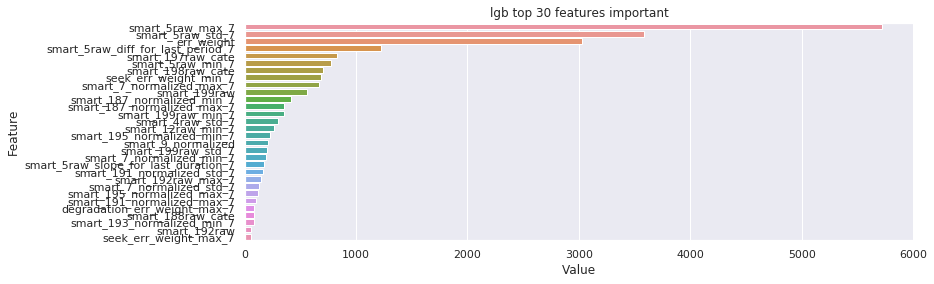

2020-04-12 09:13:18,962 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
2020-04-12 09:13:19,941 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-12 09:13:19,942 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:

[1]	training's auc: 0.658585	training's focal_loss: 0.0549833	valid_1's auc: 0.66511	valid_1's focal_loss: 0.0545967
Training until validation scores don't improve for 5 rounds.
[2]	training's auc: 0.658917	training's focal_loss: 0.0542712	valid_1's auc: 0.665509	valid_1's focal_loss: 0.0538794
[3]	training's auc: 0.664015	training's focal_loss: 0.0535712	valid_1's auc: 0.671262	valid_1's focal_loss: 0.0531743
[4]	training's auc: 0.664012	training's focal_loss: 0.0528821	valid_1's auc: 0.671262	valid_1's focal_loss: 0.05248
[5]	training's auc: 0.664844	training's focal_loss: 0.0522045	valid_1's auc: 0.671533	valid_1's focal_loss: 0.0517971
[6]	training's auc: 0.664848	training's focal_loss: 0.0515376	valid_1's auc: 0.67155	valid_1's focal_loss: 0.051125
[7]	training's auc: 0.664846	training's focal_loss: 0.0508815	valid_1's auc: 0.671565	valid_1's focal_loss: 0.0504638
[8]	training's auc: 0.664849	training's focal_loss: 0.0502359	valid_1's auc: 0.671536	valid_1's focal_loss: 0.049813
[

2020-04-12 09:16:24,826 - mlpipeline.train - INFO - eval最优轮数: 7, eval最优auc: 0.6715645345232264
2020-04-12 09:16:24,827 - mlpipeline.train - INFO - 模型训练用时:0:05:33
2020-04-12 09:16:24,836 - mlpipeline.train - INFO - 特征重要性：          Value                                        Feature
48  9446.253349                               smart_5raw_std_7
65  5212.087029              smart_5raw_diff_for_last_period_7
36  2167.735493                               err_weight_max_7
2   1800.073933                              smart_198raw_cate
19  1753.211182                               err_weight_min_7
18   744.050106                             smart_199raw_min_7
20   739.993904                          seek_err_weight_min_7
14   653.695999                               smart_5raw_min_7
31   489.408298                               smart_5raw_max_7
7    451.537003                       smart_7_normalized_min_7
24   404.875095                       smart_7_normalized_max_7
1    357.467800         

[12]	training's auc: 0.664858	training's focal_loss: 0.0477576	valid_1's auc: 0.671532	valid_1's focal_loss: 0.0473137
Early stopping, best iteration is:
[7]	training's auc: 0.664846	training's focal_loss: 0.0508815	valid_1's auc: 0.671565	valid_1's focal_loss: 0.0504638


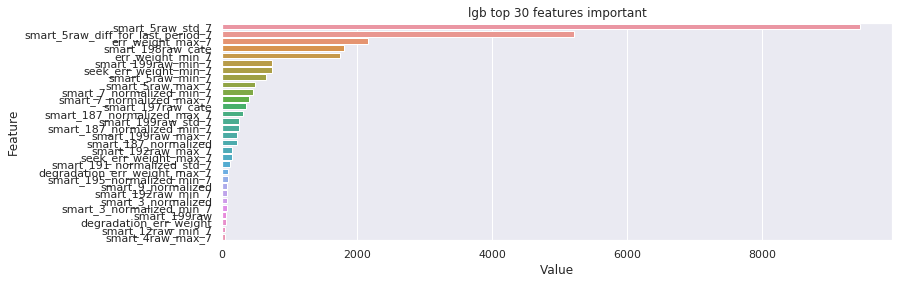

2020-04-12 09:16:34,670 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-12 09:16:35,692 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-12 09:16:35,693 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-12 09:16:36,702 - mlpipeline.train - INFO - 原始预测为fault disk的个数：636
2020-04-12 09:16:36,703 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-12 09:16:37,717 - mlpipeline.train - INFO - 原始预测为fault disk的个数：646
2020-04-12 09:16:37,718 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-12 09:16:38,720 - mlpipeline.train - INFO - 原始预测为fault disk的个数：637
2020-04-12 09:16:38,722 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-12 09:16:39,754 - mlpipeline.train - INFO - 原始预测为fault disk的个数：636
2020-04-12 09:16:39,755 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-12 09:16:40,756 - mlpipeline.train - INFO - 原始预测为fault disk的个数：639
2020-04-12 09:16:40,757 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-12 

[1]	training's auc: 0.757016	training's focal_loss: 0.00300395	valid_1's auc: 0.729605	valid_1's focal_loss: 0.00283147
Training until validation scores don't improve for 5 rounds.
[2]	training's auc: 0.766891	training's focal_loss: 0.0029754	valid_1's auc: 0.738041	valid_1's focal_loss: 0.00280292
[3]	training's auc: 0.773825	training's focal_loss: 0.0029475	valid_1's auc: 0.7406	valid_1's focal_loss: 0.00277469
[4]	training's auc: 0.773601	training's focal_loss: 0.00291984	valid_1's auc: 0.743559	valid_1's focal_loss: 0.00274686
[5]	training's auc: 0.772891	training's focal_loss: 0.00289259	valid_1's auc: 0.74259	valid_1's focal_loss: 0.00271943
[6]	training's auc: 0.773099	training's focal_loss: 0.00286578	valid_1's auc: 0.74321	valid_1's focal_loss: 0.00269232
[7]	training's auc: 0.773208	training's focal_loss: 0.00283924	valid_1's auc: 0.743437	valid_1's focal_loss: 0.00266547
[8]	training's auc: 0.777269	training's focal_loss: 0.00281314	valid_1's auc: 0.743841	valid_1's focal_lo

2020-04-12 09:19:59,994 - mlpipeline.train - INFO - eval最优轮数: 8, eval最优auc: 0.7438406974581672
2020-04-12 09:19:59,996 - mlpipeline.train - INFO - 模型训练用时:0:09:08
2020-04-12 09:20:00,005 - mlpipeline.train - INFO - 特征重要性：          Value                                        Feature
89  5514.828522                                     err_weight
31  5274.825218                               smart_5raw_max_7
48   763.369032                               smart_5raw_std_7
35   707.322006                             smart_199raw_max_7
1    525.444798                              smart_197raw_cate
20   506.199925                          seek_err_weight_min_7
65   296.799023              smart_5raw_diff_for_last_period_7
24   247.366961                       smart_7_normalized_max_7
2    209.377984                              smart_198raw_cate
25   171.066319                     smart_187_normalized_max_7
12   170.528583                     smart_195_normalized_min_7
4    165.006761         

[13]	training's auc: 0.781635	training's focal_loss: 0.00268804	valid_1's auc: 0.743065	valid_1's focal_loss: 0.0025123
Early stopping, best iteration is:
[8]	training's auc: 0.777269	training's focal_loss: 0.00281314	valid_1's auc: 0.743841	valid_1's focal_loss: 0.00263905


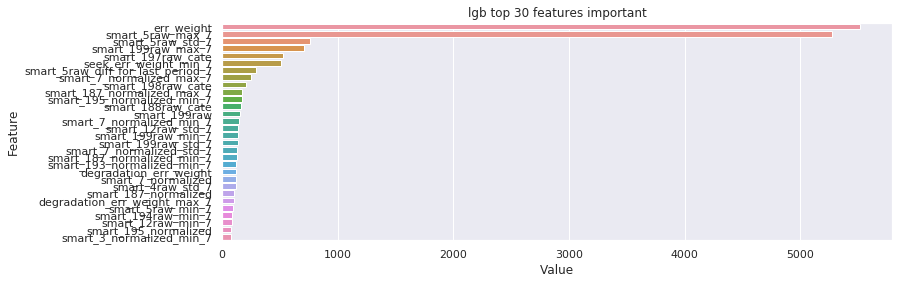

2020-04-12 09:20:09,991 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-12 09:20:11,026 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-12 09:20:11,027 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-12 09:20:12,065 - mlpipeline.train - INFO - 原始预测为fault disk的个数：644
2020-04-12 09:20:12,067 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-12 09:20:13,099 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-12 09:20:13,100 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-12 09:20:14,120 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-04-12 09:20:14,122 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-12 09:20:15,171 - mlpipeline.train - INFO - 原始预测为fault disk的个数：644
2020-04-12 09:20:15,172 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-12 09:20:16,190 - mlpipeline.train - INFO - 原始预测为fault disk的个数：649
2020-04-12 09:20:16,191 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-12 

[1]	training's auc: 0.65861	training's focal_loss: 0.0523637	valid_1's auc: 0.664961	valid_1's focal_loss: 0.0519443
Training until validation scores don't improve for 5 rounds.
[2]	training's auc: 0.66059	training's focal_loss: 0.0516851	valid_1's auc: 0.665411	valid_1's focal_loss: 0.0512604
[3]	training's auc: 0.663967	training's focal_loss: 0.0510183	valid_1's auc: 0.671186	valid_1's focal_loss: 0.0505884
[4]	training's auc: 0.66398	training's focal_loss: 0.0503625	valid_1's auc: 0.671181	valid_1's focal_loss: 0.0499276
[5]	training's auc: 0.664814	training's focal_loss: 0.0497176	valid_1's auc: 0.671438	valid_1's focal_loss: 0.0492774
[6]	training's auc: 0.66482	training's focal_loss: 0.0490834	valid_1's auc: 0.671473	valid_1's focal_loss: 0.048638
[7]	training's auc: 0.664814	training's focal_loss: 0.0484595	valid_1's auc: 0.671486	valid_1's focal_loss: 0.048009
[8]	training's auc: 0.664823	training's focal_loss: 0.0478456	valid_1's auc: 0.671582	valid_1's focal_loss: 0.0473897
[

2020-04-12 09:23:54,781 - mlpipeline.train - INFO - eval最优轮数: 11, eval最优auc: 0.6715908872326941
2020-04-12 09:23:54,783 - mlpipeline.train - INFO - 模型训练用时:0:13:03
2020-04-12 09:23:54,791 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
48  12855.411480                               smart_5raw_std_7
65   8478.369263              smart_5raw_diff_for_last_period_7
36   4596.164982                               err_weight_max_7
2    2836.369453                              smart_198raw_cate
19   2655.429398                               err_weight_min_7
89   2304.768703                                     err_weight
35   1375.980392                             smart_199raw_max_7
14   1157.711617                               smart_5raw_min_7
20    953.430096                          seek_err_weight_min_7
7     927.646706                       smart_7_normalized_min_7
24    773.554520                       smart_7_normalized_max_7
73    705.6

[16]	training's auc: 0.673248	training's focal_loss: 0.0432778	valid_1's auc: 0.668341	valid_1's focal_loss: 0.0427798
Early stopping, best iteration is:
[11]	training's auc: 0.664818	training's focal_loss: 0.0460629	valid_1's auc: 0.671591	valid_1's focal_loss: 0.0455911


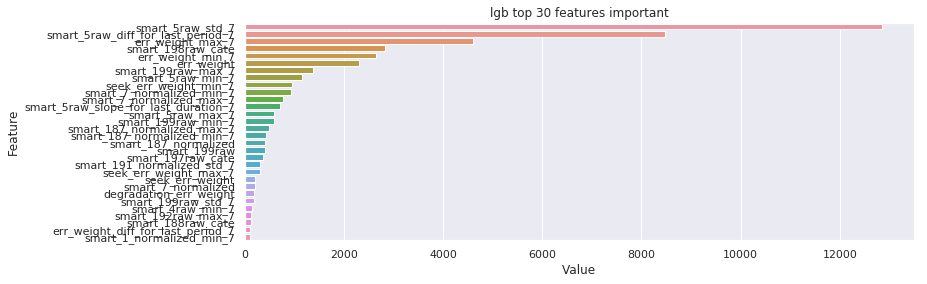

2020-04-12 09:24:04,685 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-12 09:24:05,733 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-12 09:24:05,735 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-12 09:24:06,756 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-12 09:24:06,757 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-12 09:24:07,781 - mlpipeline.train - INFO - 原始预测为fault disk的个数：644
2020-04-12 09:24:07,783 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-12 09:24:08,794 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-04-12 09:24:08,795 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-12 09:24:10,313 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-12 09:24:10,314 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-12 09:24:11,443 - mlpipeline.train - INFO - 原始预测为fault disk的个数：650
2020-04-12 09:24:11,444 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-12 

[1]	training's auc: 0.722046	training's focal_loss: 0.010823	valid_1's auc: 0.701848	valid_1's focal_loss: 0.0105536
Training until validation scores don't improve for 5 rounds.
[2]	training's auc: 0.750005	training's focal_loss: 0.0107007	valid_1's auc: 0.720989	valid_1's focal_loss: 0.0104305
[3]	training's auc: 0.7529	training's focal_loss: 0.0105808	valid_1's auc: 0.723629	valid_1's focal_loss: 0.0103095
[4]	training's auc: 0.758493	training's focal_loss: 0.0104623	valid_1's auc: 0.732287	valid_1's focal_loss: 0.01019
[5]	training's auc: 0.758356	training's focal_loss: 0.0103459	valid_1's auc: 0.732824	valid_1's focal_loss: 0.0100727
[6]	training's auc: 0.760371	training's focal_loss: 0.0102307	valid_1's auc: 0.735051	valid_1's focal_loss: 0.00995674
[7]	training's auc: 0.763136	training's focal_loss: 0.0101171	valid_1's auc: 0.736421	valid_1's focal_loss: 0.00984179
[8]	training's auc: 0.7641	training's focal_loss: 0.0100053	valid_1's auc: 0.736153	valid_1's focal_loss: 0.00972902

2020-04-12 09:28:25,698 - mlpipeline.train - INFO - eval最优轮数: 14, eval最优auc: 0.7397878135179135
2020-04-12 09:28:25,700 - mlpipeline.train - INFO - 模型训练用时:0:17:34
2020-04-12 09:28:25,708 - mlpipeline.train - INFO - 特征重要性：          Value                                        Feature
89  9603.588136                                     err_weight
31  5770.975209                               smart_5raw_max_7
36  4087.940504                               err_weight_max_7
19  3794.072025                               err_weight_min_7
14  2027.572300                               smart_5raw_min_7
73  1854.751512           smart_5raw_slope_for_last_duration_7
84  1799.383980                                     smart_5raw
48  1462.199426                               smart_5raw_std_7
65  1187.820541              smart_5raw_diff_for_last_period_7
35  1050.889247                             smart_199raw_max_7
18   848.956078                             smart_199raw_min_7
7    796.823068        

[19]	training's auc: 0.765086	training's focal_loss: 0.00887894	valid_1's auc: 0.739723	valid_1's focal_loss: 0.00858883
Early stopping, best iteration is:
[14]	training's auc: 0.763685	training's focal_loss: 0.00936865	valid_1's auc: 0.739788	valid_1's focal_loss: 0.00908488


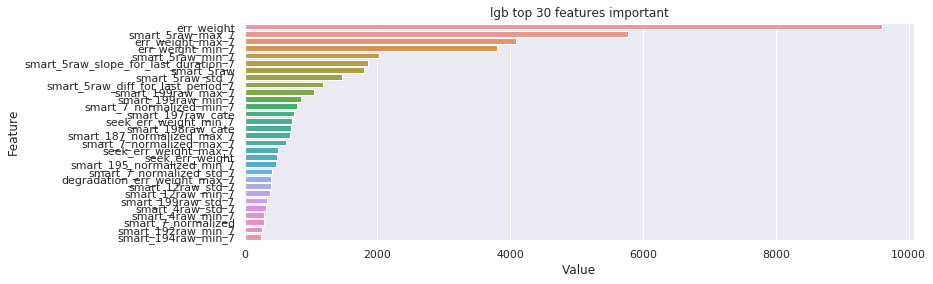

2020-04-12 09:28:35,686 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-04-12 09:28:36,742 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-04-12 09:28:36,743 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-04-12 09:28:37,774 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-12 09:28:37,775 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-04-12 09:28:38,811 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-04-12 09:28:38,813 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-04-12 09:28:39,848 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-04-12 09:28:39,849 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-04-12 09:28:40,999 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-04-12 09:28:41,000 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-04-12 09:28:42,038 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-04-12 09:28:42,040 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-04-12 

In [ ]:
results,best_params, feats_imp = tune_params_wrapper(params) 

In [11]:
results[0]

{'objective': 'binary',
 'boosting': 'gbdt',
 'learning_rate': 0.01,
 'metric': ['auc'],
 'num_threads': 15,
 'random_state': 2019,
 'num_boost_round': 1000,
 'device': 'cpu',
 'num_leaves': 32,
 'subsample': 0.7276477711272288,
 'colsample_bytree': 0.5554159286352783,
 'min_data_in_leaf': 40,
 'lambda_l1': 2.2144640274531553,
 'lambda_l2': 2.322680676967851,
 'focal_loss_alpha': 0.7652956522090006,
 'focal_loss_gamma': 1.0969048378710837,
 'f1_score': 0.2624446714334355,
 'n_estimators': 10,
 'precision': 0.22596153846153846,
 'recall': 0.31297709923664124}

In [ ]:
feats_imp

2020-04-12 16:55:24,654 - mlpipeline.train - INFO - train开始
2020-04-12 16:55:24,656 - mlpipeline.train - INFO - 当前模式:eval, eval on model None, train on model None, 使用的数据集:fe_df_01_01_round_2_submissionv1.1.feather, 当前使用模型:lgb, 使用cv: False, use_random_search: False, 训练集日期:2018-01-01 - 2018-05-31, 验证集日期:2018-07-01 - 2018-07-31, 分类阈值: 0.996, 截断个数: 40, 下采样：True, 上采样：False, 用的label：tag
2020-04-12 16:55:27,029 - mlpipeline.train - INFO - _sampling开始
2020-04-12 16:56:03,506 - mlpipeline.train - INFO - 负样本数：22173226, 需采样训练集负样本ratio或个数：0.3,样本数:6651967
100%|██████████| 4/4 [00:23<00:00,  5.92s/it]
2020-04-12 16:57:39,079 - mlpipeline.train - INFO - _sampling已完成，共用时0:02:12
2020-04-12 16:57:52,610 - mlpipeline.train - INFO - 采样文件已保存至: ../data/sample_by_power_on_hours_0.3_fe_df_01_01_round_2_submissionv1.1.feather
2020-04-12 16:57:58,041 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-04-12 16:57:58,049 - mlpipeline.train - INFO - 连续性特征数量: 83
2020-04-12 16:57:58,050 - mlpipeline.train - INFO 

[1]	training's auc: 0.737904	training's focal_loss: 0.0352526	valid_1's auc: 0.714567	valid_1's focal_loss: 0.0344643
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.766011	training's focal_loss: 0.0348216	valid_1's auc: 0.712597	valid_1's focal_loss: 0.034027
[3]	training's auc: 0.763983	training's focal_loss: 0.0343969	valid_1's auc: 0.717628	valid_1's focal_loss: 0.0335964
[4]	training's auc: 0.766506	training's focal_loss: 0.03398	valid_1's auc: 0.718554	valid_1's focal_loss: 0.0331735
[5]	training's auc: 0.774111	training's focal_loss: 0.0335723	valid_1's auc: 0.734152	valid_1's focal_loss: 0.0327578


2020-04-12 17:00:29,630 - mlpipeline.train - INFO - eval最优轮数: 6, eval最优auc: 0.7325970698881515
2020-04-12 17:00:29,632 - mlpipeline.train - INFO - 模型训练用时:0:01:43
2020-04-12 17:00:29,641 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
45  20519.907379                               smart_5raw_std_7
18   5450.414692                               err_weight_min_7
69   4358.298203           smart_5raw_slope_for_last_duration_7
1    3375.080078                              smart_197raw_cate
33   1477.737976                             smart_199raw_max_7
34   1159.645161                               err_weight_max_7
71   1131.745781                           smart_187_normalized
11    635.947502                     smart_195_normalized_min_7
19    549.721901                          seek_err_weight_min_7
7     464.954205                       smart_7_normalized_min_7
10    356.557007                     smart_191_normalized_min_7
86    342.46

[6]	training's auc: 0.774786	training's focal_loss: 0.033169	valid_1's auc: 0.732597	valid_1's focal_loss: 0.0323484
Did not meet early stopping. Best iteration is:
[6]	training's auc: 0.774786	training's focal_loss: 0.033169	valid_1's auc: 0.732597	valid_1's focal_loss: 0.0323484


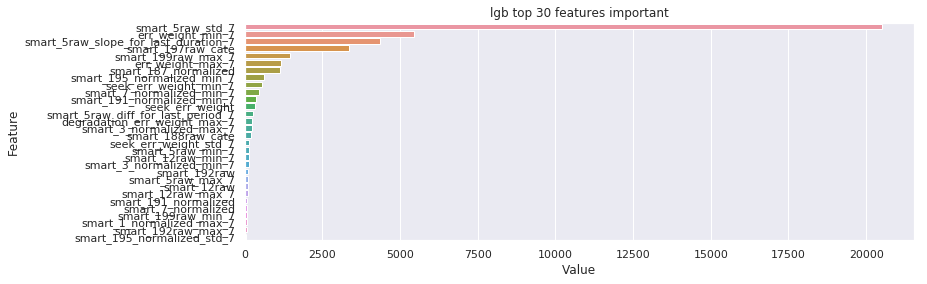

2020-04-12 17:00:39,363 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
2020-04-12 17:00:40,204 - mlpipeline.train - INFO - 原始预测为fault disk的个数：616
2020-04-12 17:00:40,206 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:

In [9]:
# eval
model_params = {'objective': 'binary', 
'boosting': 'gbdt',
 'learning_rate': 0.01, 
 'num_leaves': 16, 
 'metric': ['auc'], 
 'subsample': 0.7, 
 'colsample_bytree': 0.30000000000000004, 
 'num_threads': 15,
  'lambda_l2': 1.6554674976661803, 
  'lambda_l1': 0.33202583076253445, 
  'random_state': 2019, 
  'min_data_in_leaf': 20, 
  'num_boost_round': 6, 
  'device': 'cpu',
  'focal_loss_alpha': 0.9, 
  'focal_loss_gamma': 1.0}
    
params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'fe_df_01_01_round_2_submissionv1.1.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
    'is_eval': True,
    'use_log': False,
    'drop_cols':drop_cols,
    'use_sampling': True,
#   'use_sampling_by_month_with_weight':True,
#   'use_sampling_by_clustering_label':True,
    'use_sampling_by_power_on_hours':True,
    'use_up_sampling_by_smote':False,
    'train_sample_ratio':0.3,
    'valid_sample_ratio':None,
    'save_sample_data':True,
    'random_state':1,
    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
    'eval_on_model_id': None, # 1,2,None
    'train_on_model_id':None, # 1 ,2 , None
    'save_feat_important': False,
    'use_2017_fault_data':True,
    'use_next_month_fault_data':True,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
}
model, eval_df,feat_imp = train(**params) 

2020-04-12 17:55:38,133 - mlpipeline.train - INFO - train开始
2020-04-12 17:55:38,135 - mlpipeline.train - INFO - 当前模式:train, 使用的数据集:lgb, 当前使用模型:sample_by_power_on_hours_0.3_fe_df_01_01_round_2_submissionv1.1.feather, 训练日期:2018-01-01 - 2018-05-31
2020-04-12 17:55:45,101 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-04-12 17:55:45,105 - mlpipeline.train - INFO - 连续性特征数量: 83
2020-04-12 17:55:45,106 - mlpipeline.train - INFO - 离散性特征数量: 5
2020-04-12 17:56:24,275 - mlpipeline.train - INFO - 训练集正负样本比:24921:6651964(i.e. 0.00375)
2020-04-12 17:56:24,277 - mlpipeline.train - INFO - train参数:{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 16, 'metric': ['auc'], 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'num_threads': 15, 'lambda_l2': 1.6554674976661803, 'lambda_l1': 0.33202583076253445, 'random_state': 2019, 'min_data_in_leaf': 20, 'num_boost_round': 6, 'device': 'cpu', 'focal_loss_alpha': 0.9, 'focal_loss_gamma': 1.0}


[1]	training's auc: 0.737904	training's focal_loss: 0.0352526
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.766011	training's focal_loss: 0.0348216
[3]	training's auc: 0.763983	training's focal_loss: 0.0343969
[4]	training's auc: 0.766506	training's focal_loss: 0.03398
[5]	training's auc: 0.774111	training's focal_loss: 0.0335723


2020-04-12 17:57:35,149 - mlpipeline.train - INFO - eval最优轮数: 6, eval最优auc: 0.7747858643794664
2020-04-12 17:57:35,152 - mlpipeline.train - INFO - 模型训练用时:0:01:11
2020-04-12 17:57:35,160 - mlpipeline.train - INFO - 特征重要性：           Value                                        Feature
45  20519.907379                               smart_5raw_std_7
18   5450.414692                               err_weight_min_7
69   4358.298203           smart_5raw_slope_for_last_duration_7
1    3375.080078                              smart_197raw_cate
33   1477.737976                             smart_199raw_max_7
34   1159.645161                               err_weight_max_7
71   1131.745781                           smart_187_normalized
11    635.947502                     smart_195_normalized_min_7
19    549.721901                          seek_err_weight_min_7
7     464.954205                       smart_7_normalized_min_7
10    356.557007                     smart_191_normalized_min_7
86    342.46

[6]	training's auc: 0.774786	training's focal_loss: 0.033169
Did not meet early stopping. Best iteration is:
[6]	training's auc: 0.774786	training's focal_loss: 0.033169


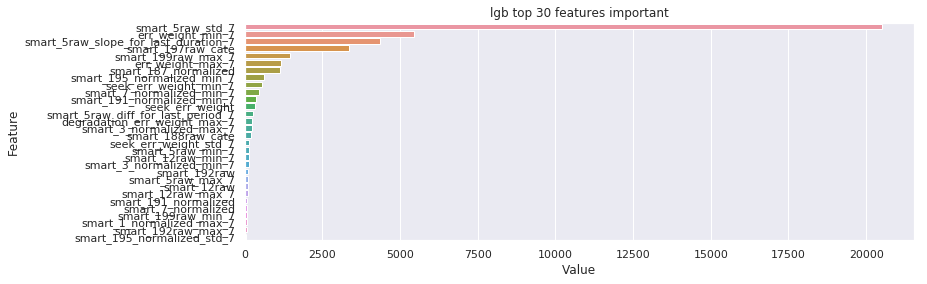

2020-04-12 17:57:36,211 - mlpipeline.train - INFO - train_pipeline_lgb已完成，共用时0:01:51
2020-04-12 17:57:37,067 - mlpipeline.train - INFO - lgb模型训练完成!模型保存至:../trained_model/lgb.model.2020-04-12T17:55:45.101148
2020-04-12 17:57:37,068 - mlpipeline.train - INFO - train已完成，共用时0:01:59


In [10]:
# train
model_params = {'objective': 'binary', 
'boosting': 'gbdt',
 'learning_rate': 0.01, 
 'num_leaves': 16, 
 'metric': ['auc'], 
 'subsample': 0.7, 
 'colsample_bytree': 0.30000000000000004, 
 'num_threads': 15,
  'lambda_l2': 1.6554674976661803, 
  'lambda_l1': 0.33202583076253445, 
  'random_state': 2019, 
  'min_data_in_leaf': 20, 
  'num_boost_round': 6, 
  'device': 'cpu',
  'focal_loss_alpha': 0.9, 
  'focal_loss_gamma': 1.0}

params = {
    'is_eval':False,
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename':  'sample_by_power_on_hours_0.3_fe_df_01_01_round_2_submissionv1.1.feather',
    'use_sampling': False,
#     'train_sample_ratio':0.4,
#     'save_sample_data':False,
#     'use_sampling_by_month_with_weight':False,
#     'use_sampling_by_clustering_label':False,
#     'use_sampling_by_power_on_hours':True,
    'random_state':1,
    'drop_cols': drop_cols,
    'train_on_model_id':None,
    'use_log': False,
    'use_2017_fault_data':True,
    'use_next_month_fault_data':True,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'train_start_date': '2018-01-01',
    'train_end_date': '2018-05-31',
#     'valid_start_date':'2018-09-01', 
}

model = train(**params)

In [6]:
# predict 
params = {
          'model_name': 'lgb',
          'pred_start_date': '2018-08-11',
          'pred_end_date':'2018-08-13',
          'num_processes':8,
          'use_log': False,
            }

submission_df = predict(**params)

2020-04-12 18:29:58,806 - mlpipeline.predict - INFO - predict开始
2020-04-12 18:29:58,837 - mlpipeline.predict - INFO - 开始预测, 当前使用模型:lgb
2020-04-12 18:29:58,863 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-04-12 18:29:58,864 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: False，数据集截断起始日期：None, 数据集截断结束日期：None
2020-04-12 18:29:58,865 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-04-12 18:29:58,866 - mlpipeline.feature_engineering - INFO - 加载数据集: ../tcdata/disk_sample_smart_log_round2
2020-04-12 18:29:58,867 - mlpipeline.feature_engineering - INFO - _get_pred_data开始
2020-04-12 18:29:59,446 - mlpipeline.feature_engineering - INFO - _get_pred_data已完成，共用时0:00:01
2020-04-12 18:29:59,449 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['serial_number', 'model', 'smart_1_normalized', 'smart_3_normalized', 'smart_4raw',
       'smart_5raw', 'smart_7_normalized', 'smart_9_normalized', 'smart_9raw', 'smart_12raw',
       'smart_184raw

2020-04-12 18:31:59,667 - mlpipeline.predict - INFO - predict已完成，共用时0:02:01
